## Analysis of model coefficients

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
pancancer_dir = os.path.join(cfg.results_dir, 'pancancer')
single_cancer_dir = os.path.join(cfg.results_dir, 'single_cancer')

For the pan-cancer experiments, we added covariates (e.g. fixed effects, dummy/one-hot encoded variables) for the cancer types present in the dataset.

Here, we want to look at the proportion of models in which the coefficient for these cancer type covariates. Are they mostly zero (since we're using elastic net regularization), or are they often informative? Does this differ between models that outperform the negative control and models that don't?

In [3]:
sample_info_df = du.load_sample_info()
tcga_cancer_types = list(np.unique(sample_info_df.cancer_type))

identifier_coefs_info = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        cancer_covs = au.get_cancer_type_covariates(coefs, tcga_cancer_types)
        identifier_coefs_info.append((identifier, fold_no, len(cancer_covs), cancer_covs))
        
# TODO: do we need a way to generate list of all features?
ids_df = pd.DataFrame(identifier_coefs_info, columns=['identifier', 'fold', 'nz_cov_count', 'nz_covs'])
ids_df[ids_df.nz_cov_count > 0].head(n=10)

,identifier,fold,nz_cov_count,nz_covs
0,MAP3K1_BRCA,0,1,[BRCA]
9,MLH1_UCEC,1,1,[UCEC]
10,MLH1_UCEC,2,1,[UCEC]
160,CIC_SKCM,0,1,[LGG]
256,CBL_UCEC,0,1,[UCEC]
258,CBL_UCEC,2,1,[UCEC]
273,JAK3_OV,1,1,[UCEC]
277,H3F3A_BRCA,1,1,[BRCA]
280,H3F3A_LIHC,0,1,[BRCA]
315,MAP2K1_SKCM,3,1,[SKCM]


In [4]:
# load significant identifiers and join into coefficients dataframe
pancancer_comparison_df = pd.read_csv(os.path.join(cfg.results_dir, 'pancancer_pvals.tsv'),
                                      index_col=False, sep='\t')
merge_df = (
    ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
          .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
merge_df.head(n=8)

,identifier,fold,nz_cov_count,nz_covs,reject_null
0,MAP3K1_BRCA,0,1,[BRCA],True
1,MAP3K1_BRCA,1,0,[],True
2,MAP3K1_BRCA,2,0,[],True
3,MAP3K1_BRCA,3,0,[],True
4,MAP3K1_UCEC,0,0,[],False
5,MAP3K1_UCEC,1,0,[],False
6,MAP3K1_UCEC,2,0,[],False
7,MAP3K1_UCEC,3,0,[],False


Text(0, 0.5, 'Number of models (fold/cancer type/gene)')

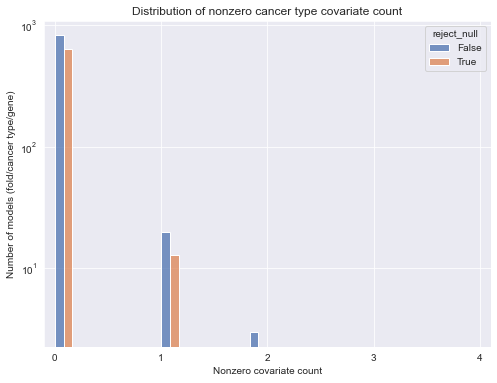

In [5]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=merge_df, x='nz_cov_count', hue='reject_null', log_scale=(False, True),
             kde=False, multiple='dodge')
plt.xticks(range(0, 5))
plt.xlim(-0.1, 4.1)
plt.title('Distribution of nonzero cancer type covariate count')
plt.xlabel('Nonzero covariate count')
plt.ylabel('Number of models (fold/cancer type/gene)')

So, it looks like the cancer type covariates are largely unused by the models, and the proportion of models using them doesn't seem to vary much between well-performing and poorly-performing models.

Now we want to do something similar for the sample mutation burden covariate ("log10_mut").

In [6]:
identifier_mut_coefs = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        mut_cov = au.get_mutation_covariate(coefs)
        identifier_mut_coefs.append((identifier, fold_no, mut_cov))
        
mut_ids_df = pd.DataFrame(identifier_mut_coefs, columns=['identifier', 'fold', 'mut_cov'])
mut_ids_df.head(n=10)

mut_merge_df = (
    mut_ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
              .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
mut_merge_df.head(n=8)

,identifier,fold,mut_cov,reject_null
0,MAP3K1_BRCA,0,True,True
1,MAP3K1_BRCA,1,True,True
2,MAP3K1_BRCA,2,False,True
3,MAP3K1_BRCA,3,True,True
4,MAP3K1_UCEC,0,False,False
5,MAP3K1_UCEC,1,True,False
6,MAP3K1_UCEC,2,True,False
7,MAP3K1_UCEC,3,False,False


/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


Text(0, 0.5, 'Number of models (fold/cancer type/gene)')

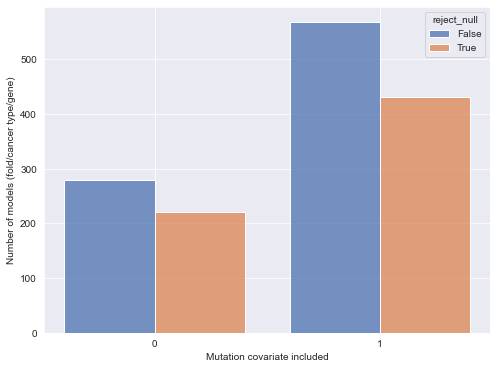

In [7]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=mut_merge_df, x='mut_cov', hue='reject_null',
             kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.xticks((0, 1))
plt.xlabel('Mutation covariate included')
plt.ylabel('Number of models (fold/cancer type/gene)')

We can see that the mutation burden covariate is included in our models fairly frequently, more than half the time. It also seems to be zeroed out more often in well-performing models than poorly-performing models. This makes sense: in the case where a mutation doesn't result in a gene expression perturbation, there should be a bit of predictive signal in mutation burden, but in the case where a mutation perturbs gene expression noticeably, signal in the mutation burden should be at least somewhat redundant to the signal in the expression data (at least in some cases).

Last, we want to look at the genes selected by elastic net. The underlying question is: are the genes selected primarily the most variable ones (i.e. genes with a high mean absolute deviation), or is the model selecting less variable genes in some cases? Again, we'll segment by well-performing/poorly-performing and see if we notice a difference.

In [8]:
# get top n genes in terms of MAD
# note the actual feature selection may be different, since it does this selection
# independently for each training set (subset of all data)
rnaseq_df = du.load_expression_data(verbose=True)
mad_genes_df = (
    rnaseq_df.mad(axis=0)
             .sort_values(ascending=False)
             .reset_index()
)
mad_genes_df.columns = ['gene_id', 'mean_absolute_deviation']
mad_genes = mad_genes_df.gene_id.astype(str).values
print(mad_genes[:5])
mad_genes_df.head()

Loading gene expression data...


['213' '7038' '1277' '2335' '3852']


,gene_id,mean_absolute_deviation
0,213,154357.230103
1,7038,77954.882427
2,1277,74338.643636
3,2335,66635.420552
4,3852,62003.720145


In [9]:
# how many of nonzero coefficients are in top n MAD genes?
n_mad_genes = 4000

identifier_mad_coefs = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        mad_proportion = au.get_mad_proportion(coefs, mad_genes[:n_mad_genes])
        identifier_mad_coefs.append((identifier, fold_no, n_mad_genes, mad_proportion))
        
# TODO: do we need a way to generate list of all features?
mad_ids_df = pd.DataFrame(identifier_mad_coefs, columns=['identifier', 'fold', 'n_mad_genes', 'mad_proportion'])
mad_ids_df.head(n=10)

,identifier,fold,n_mad_genes,mad_proportion
0,MAP3K1_BRCA,0,4000,0.457516
1,MAP3K1_BRCA,1,4000,0.422287
2,MAP3K1_BRCA,2,4000,0.500000
3,MAP3K1_BRCA,3,4000,0.456633
4,MAP3K1_UCEC,0,4000,0.452722
5,MAP3K1_UCEC,1,4000,0.397849
6,MAP3K1_UCEC,2,4000,0.442308
7,MAP3K1_UCEC,3,4000,0.583333
8,MLH1_UCEC,0,4000,0.583333
9,MLH1_UCEC,1,4000,0.490826


Text(0, 0.5, 'Number of models (fold/cancer type/gene)')

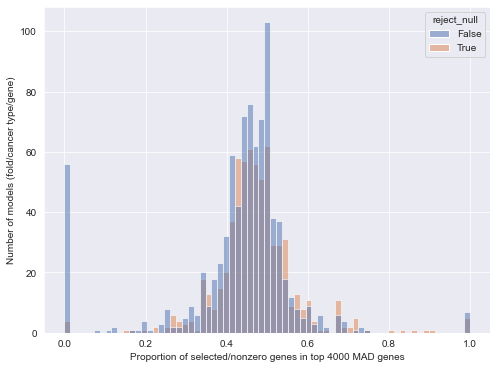

In [10]:
mad_merge_df = (
    mad_ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
              .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=mad_merge_df, x='mad_proportion', hue='reject_null', kde=False)
plt.xlabel('Proportion of selected/nonzero genes in top {} MAD genes'.format(n_mad_genes))
plt.ylabel('Number of models (fold/cancer type/gene)')

Next, we want to ask: how stable are models between folds (for the same gene and cancer type)?

We can quantify this using Jaccard similarity: treat coefficients as binary vectors (either 0 or 1=nonzero) and evaluate overlap between nonzero coefficients.

$$J(\text{model A}, \text{model B}) = \frac{|\{\beta \mid \beta_A \neq 0 \text{ and } \beta_B \neq 0\}|}{|\{\beta \mid \beta_A \neq 0 \text{ or } \beta_B \neq 0\}|}$$

In [11]:
per_fold_jaccard = []
for jaccard_analysis_dir in (single_cancer_dir, pancancer_dir):
    train_set = ('single cancer' if jaccard_analysis_dir == single_cancer_dir
                 else 'pancancer')
    for identifier, coefs_list in au.generate_nonzero_coefficients(jaccard_analysis_dir):
        # for each pairwise fold comparison, calculate jaccard index
        num_folds = len(coefs_list)
        for f1, f2 in it.combinations(range(num_folds), 2):
            try:
                nonzero_coefs_f1 = list(zip(*coefs_list[f1]))[0]
                nonzero_coefs_f2 = list(zip(*coefs_list[f2]))[0]
                inter_fold_jaccard, _, __ = au.compute_jaccard(nonzero_coefs_f1, nonzero_coefs_f2)
            except IndexError:
                # this can occur if all coefficients for a given fold were zero
                # (i.e. model predicts the mean/fits only an intercept)
                # if so, we call it a jaccard index of 0
                inter_fold_jaccard = 0.0
            per_fold_jaccard.append((identifier, f1, f2, train_set, inter_fold_jaccard))

intra_jaccard_df = pd.DataFrame(per_fold_jaccard, columns=['identifier', 'f1', 'f2', 'train_set', 'jaccard'])
intra_jaccard_merge_df = (
    intra_jaccard_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
                    .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
intra_jaccard_merge_df.head(n=10)

,identifier,f1,f2,train_set,jaccard,reject_null
0,MAP3K1_BRCA,0,1,single cancer,0.150555,True
1,MAP3K1_BRCA,0,2,single cancer,0.063291,True
2,MAP3K1_BRCA,0,3,single cancer,0.156433,True
3,MAP3K1_BRCA,1,2,single cancer,0.078431,True
4,MAP3K1_BRCA,1,3,single cancer,0.175238,True
5,MAP3K1_BRCA,2,3,single cancer,0.058981,True
6,MAP3K1_BRCA,0,1,pancancer,0.193237,True
7,MAP3K1_BRCA,0,2,pancancer,0.012739,True
8,MAP3K1_BRCA,0,3,pancancer,0.162047,True
9,MAP3K1_BRCA,1,2,pancancer,0.008721,True


Text(0.5, 1.0, 'Jaccard similarity between folds of same model, pancancer')

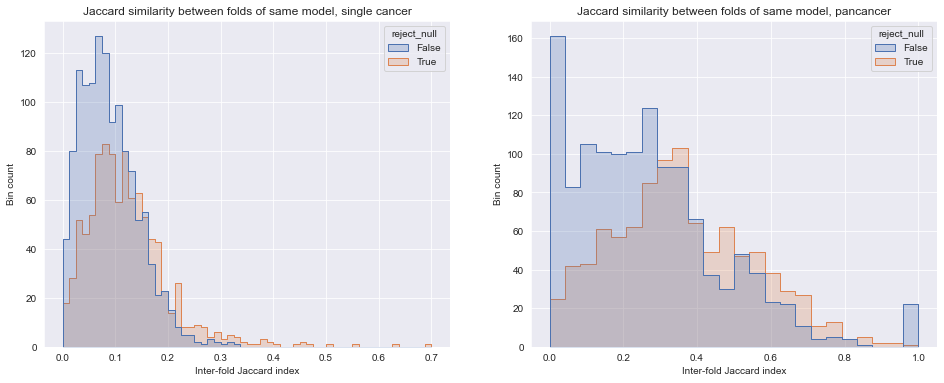

In [12]:
sns.set({'figure.figsize': (16, 6)})
fig, axarr = plt.subplots(1, 2)

sns.histplot(data=intra_jaccard_merge_df[intra_jaccard_merge_df.train_set == 'single cancer'], 
             x='jaccard', stat='count', hue='reject_null', element='step', kde=False, ax=axarr[0])
axarr[0].set_xlabel('Inter-fold Jaccard index')
axarr[0].set_ylabel('Bin count')
axarr[0].set_title('Jaccard similarity between folds of same model, single cancer')
sns.histplot(data=intra_jaccard_merge_df[intra_jaccard_merge_df.train_set == 'pancancer'], 
             x='jaccard', stat='count', hue='reject_null', element='step', kde=False, ax=axarr[1])
axarr[1].set_xlabel('Inter-fold Jaccard index')
axarr[1].set_ylabel('Bin count')
axarr[1].set_title('Jaccard similarity between folds of same model, pancancer')

In [13]:
# how stable are models between cancer types for the same gene?
genes_df = du.load_vogelstein()

inter_cancer_jaccard_df = None
for jaccard_analysis_dir in (single_cancer_dir, pancancer_dir):
    train_set = ('single cancer' if jaccard_analysis_dir == single_cancer_dir
                 else 'pancancer')
    for _, gene_series in genes_df.iterrows():
        gene = gene_series.gene
        per_gene_jaccard = {}
        for identifier, coefs_list in au.generate_nonzero_coefficients_for_gene(
                                                        jaccard_analysis_dir, gene):
            per_gene_jaccard[identifier] = coefs_list
        results_df = au.compare_inter_cancer_coefs(gene, per_gene_jaccard,
                                                   pancancer_comparison_df,
                                                   train_set=train_set)
        if inter_cancer_jaccard_df is None:
            inter_cancer_jaccard_df = results_df
        else:
            inter_cancer_jaccard_df = pd.concat((inter_cancer_jaccard_df, results_df))
            
print(inter_cancer_jaccard_df.shape)
inter_cancer_jaccard_df.head(n=10)    

(2750, 5)


,id1,id2,train_set,mean_jaccard,reject_null
0,ALK_UCEC,ALK_LUAD,single cancer,0.002542,none
1,ALK_UCEC,ALK_SKCM,single cancer,0.004947,one
2,ALK_UCEC,ALK_COAD,single cancer,0.003938,none
3,ALK_LUAD,ALK_SKCM,single cancer,0.004860,one
4,ALK_LUAD,ALK_COAD,single cancer,0.002685,none
5,ALK_SKCM,ALK_COAD,single cancer,0.005658,one
0,APC_SKCM,APC_STAD,single cancer,0.001953,none
1,APC_SKCM,APC_HNSC,single cancer,0.010012,none
2,APC_SKCM,APC_COAD,single cancer,0.009346,one
3,APC_SKCM,APC_READ,single cancer,0.006224,one


Text(0.5, 1.0, 'Same gene/different cancer types, pancancer')

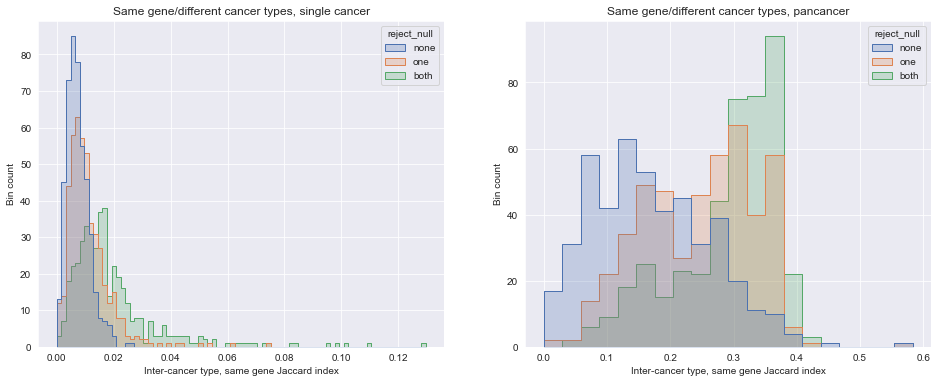

In [14]:
sns.set({'figure.figsize': (16, 6)})
fig, axarr = plt.subplots(1, 2)

sns.histplot(data=inter_cancer_jaccard_df[inter_cancer_jaccard_df.train_set == 'single cancer'],
             x='mean_jaccard', stat='count', hue='reject_null', element='step',
             kde=False, ax=axarr[0])
axarr[0].set_xlabel('Inter-cancer type, same gene Jaccard index')
axarr[0].set_ylabel('Bin count')
axarr[0].set_title('Same gene/different cancer types, single cancer')
sns.histplot(data=inter_cancer_jaccard_df[inter_cancer_jaccard_df.train_set == 'pancancer'],
             x='mean_jaccard', stat='count', hue='reject_null', element='step',
             kde=False, ax=axarr[1])
axarr[1].set_xlabel('Inter-cancer type, same gene Jaccard index')
axarr[1].set_ylabel('Bin count')
axarr[1].set_title('Same gene/different cancer types, pancancer')

We can see that for the pancancer coefficient comparisons, the model overlaps (coefficient Jaccard similarities) are fairly high, and there is a lot of separation between well-performing and poor-performing models (with well-performing models having higher overlap). This is expected since the pan-cancer training set is mostly consistent between folds or between experiments (with the exception of the cancer type under consideration), so it makes sense that the resulting model is consistent as well.

In the single-cancer case, model overlaps are much lower in general, and there is not nearly as much separation between well-performing and poorly performing models. This is a bit surprising since we're only considering models that predict mutations in the same gene, so we'd expect them to use some of the same predictors, but this doesn't really seem to be the case often. This may be due to the high level of correlation/collinearity in gene expression data (there are multiple choices of predictors that can predict the same labels, since many of the predictors convey redundant information).

Maybe looking at this from a pathway or network perspective would help to elucidate this; that is, even if the model selects different genes between folds, we'd expect them to be in the same pathway, or to be close together in a gene interaction network.